In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from embedding_utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

# percentage of fully reconstructed smiles

### Data & Model Parameters

In [2]:
smiles = fetch_smiles_gdb13('./data/gdb13').values.tolist()

for i, smile in enumerate(smiles):
    smiles[i] = smile.replace('Cl', 'L')

### Model

In [3]:
params = make_params(smiles=smiles, GRU_HIDDEN_DIM=512, LATENT_DIM=256)

In [4]:
encoder = Encoder(params)
encoder.load_state_dict(torch.load('weights-5/encoder_weights.pth'))

decoder = Decoder(params)
decoder.load_state_dict(torch.load('weights-5/decoder_weights.pth'))

<All keys matched successfully>

[NH3+]C1C2CC34CC5OC(C2C3)C14O5		O1C=CC2=NN=C3C=COC1=C23
[NH3+]C1C2CC34CC5CC(C1)C)C14O5		O1C=CC2=CC=C3=C=CC1=C23
Euclidean Distance of Means: 35.94603729248047
Euclidean Distance of Samples: 35.94768142700195


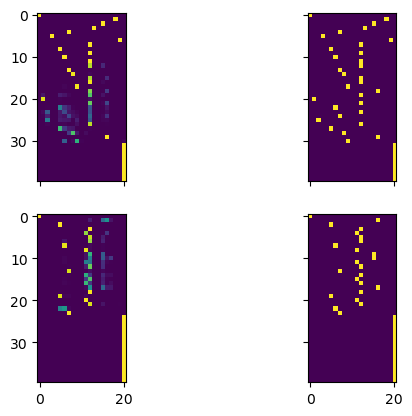

In [5]:
s1, s2 = random.sample(smiles, 2)
print(f'{s1}\t\t{s2}')

s1 = to_one_hot(s1, params)
s2 = to_one_hot(s2, params)

mu1, logvar1, z1 = encoder(s1)
mu2, logvar2, z2 = encoder(s2)

s1_pred = decoder(z1)
s2_pred = decoder(z2)

print(f'{from_one_hot(s1_pred, params)[0]}\t\t{from_one_hot(s2_pred, params)[0]}')

print(f"Euclidean Distance of Means: {float(torch.pow(torch.sum(torch.pow(mu1 - mu2, 2)), 0.5))}")
print(f"Euclidean Distance of Samples: {float(torch.pow(torch.sum(torch.pow(z1 - z2, 2)), 0.5))}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

ax1.imshow(torch.softmax(s1_pred, dim=2).squeeze(0).detach().numpy())
ax2.imshow(torch.softmax(s1, dim=2).squeeze(0).detach().numpy())

ax3.imshow(torch.softmax(s2_pred, dim=2).squeeze(0).detach().numpy())
ax4.imshow(torch.softmax(s2, dim=2).squeeze(0).detach().numpy())

## Test

In [6]:
evaluate_ae(encoder, decoder, smiles, 10, params=params)

,target,predicted
0,C1OCC2CC3=C(CC12)NC=N3,C1OCC2CC3=C(CCC2)C=CN3
1,C1OCC23CCC4(COC(C4)C12)O3,C1OCC23CCC4(COCCCC)C13)O3
2,NC1=CC2=C(CCC3=COC=C23)S1,NC1=CC2=C(CCC3=CSC=C23)S1
3,C1OC2C3NC=[NH+]C33COC2C1C3,C1OC2C3CC=[NH+]CCC3CC1C1C3
4,C1CC2OC3C[NH2+]C2CC1OCC3,C1CC2OC3C[NH2+]C2CCCCCC3
5,NC1=NNC2=C1CN1C=CC=C1C2,NC1=NNC2=C1CC1==CC=C1C2
6,OC1C2CC34CCC(OC(C3)O2)C14,OC1C2CC34CCC(CCCCCCO2)C14
7,OC12CCC3CC(C1)CC23O,OC12CCC3CC(C1)CCC2O
8,C1[NH2+]C2CC1CN1N=CC(CC2)=N1,C1[NH2+]C2CC1CC11=N(CCC2)=N1
9,C1[NH2+]C2CN3C4CC5CC4NC25C13,C1[NH2+]C2CN3C4CC5CCCCC25C13


In [ ]:
log = pd.read_csv('./logs/log-5.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

every = 1

ax1.set_ylabel('loss')
ax1.plot(log['loss'][::every], color='red')

ax2.set_ylabel('accuracy')
ax2.plot(log['similarity'][::every])

plt.tight_layout()